In [20]:
import pandas as pd
import pickle
import random
from rdkit import Chem
import itertools
import torch
import numpy as np
from enhancement_utility import generate_smiles, smiles_to_fingerprint

seed = 12

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [21]:
df = pd.read_csv('Denmark_cleaned.csv', index_col=False)
print(df.head())
pickle_path = 'Denmark.pkl'

with open(pickle_path, 'rb') as file:
        model = pickle.load(file)

proxy_model = model.predict
THRESHOLD = 0.7

                                            Catalyst  \
0  O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...   
1  O=P1(O)OC2=C(C3=CC(C4=C(C)C=C(C)C=C4C)=CC(C5=C...   
2  O=P1(O)OC2=C(C3=CC=C(OC)C=C3)C=C4C(C=CC=C4)=C2...   
3  O=P1(O)OC2=[C@]([C@]3=C(Cl)C=C(Cl)C=C3Cl)C=C4C...   
4  O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C...   

                                      Imine             Thiol  Delta_Delta_G  
0    O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl     SC1=CC=CC=C1C       3.134625  
1      O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2  SC1=CC=C(OC)C=C1       1.531803  
2    O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl      SC1=CC=CC=C1       1.074991  
3      O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2     SC1=CC=CC=C1C       1.334823  
4  O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3      SC1=CC=CC=C1       1.743658  


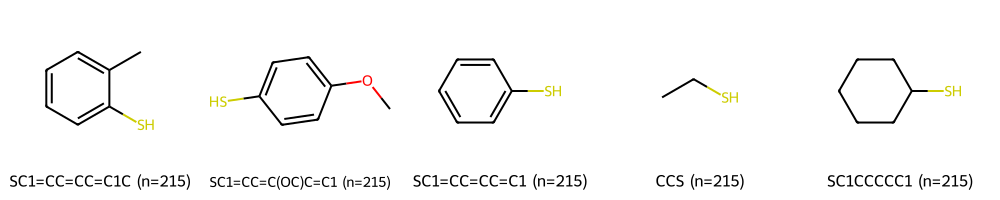

In [22]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Calculate the frequency of each unique SMILES
frequency = df['Thiol'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'Thiol': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['Thiol'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['Thiol'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)


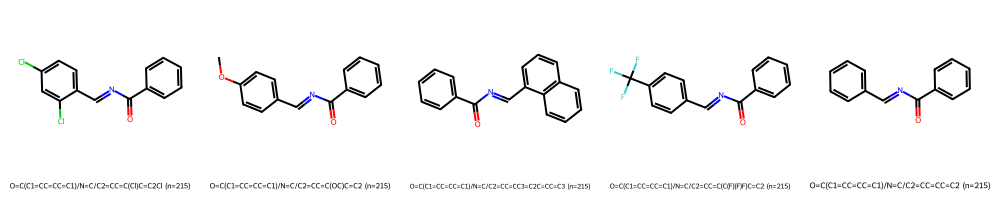

In [23]:
# Calculate the frequency of each unique SMILES
frequency = df['Imine'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'Imine': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['Imine'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['Imine'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)


In [24]:
imines = df['Imine'].to_list()
random.shuffle(imines)
thiols = df['Thiol'].to_list()
random.shuffle(thiols)
catalysts = list(set(df['Catalyst'].to_list()))

imines_enhanced = []
thiols_enhanced = []

In [25]:
for imine in imines:
    imines_enhanced.extend(generate_smiles(imine))

for thiol in thiols:
    thiols_enhanced.extend(generate_smiles(thiol))

In [26]:
imine_pattern = Chem.MolFromSmarts('[NX2]=[CX3]')
imines_filtered = []

for smi in imines_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(imine_pattern):
        imines_filtered.append(smi)

imines_filtered = list(set(imines_filtered))
print(len(imines_filtered))

45


In [27]:
thiol_pattern = Chem.MolFromSmarts('[CX4][SH]')
thiols_filtered = []

for smi in thiols_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(thiol_pattern):
        thiols_filtered.append(smi)

thiols_filtered = list(set(thiols_filtered))
print(len(thiols_filtered))

10


In [28]:
combinations_imine = list(itertools.product(catalysts, imines_filtered, list(set(thiols))))
print(len(combinations_imine), len(imines_filtered), len(list(set(thiols))))
df_enhanced_imine = pd.DataFrame(combinations_imine, columns=['Catalyst', 'Imine', 'Thiol'])
print(df_enhanced_imine.head(), len(df_enhanced_imine))

9675 45 5
                                            Catalyst  \
0  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
1  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
2  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
3  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
4  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   

                             Imine             Thiol  
0  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1               CCS  
1  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1      SC1=CC=CC=C1  
2  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1  SC1=CC=C(OC)C=C1  
3  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1         SC1CCCCC1  
4  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1     SC1=CC=CC=C1C   9675


In [29]:
fingerprints = []
for index, row in df_enhanced_imine.iterrows():
    catalyst_fp = smiles_to_fingerprint(row['Catalyst'])
    imine_fp = smiles_to_fingerprint(row['Imine'])
    thiol_fp = smiles_to_fingerprint(row['Thiol'])

    concatenated_fp = torch.cat((catalyst_fp, imine_fp, thiol_fp))
    fingerprints.append(concatenated_fp)
    
X_imine = torch.stack(fingerprints)
print(X_imine.shape)

y_imine = proxy_model(X_imine)
print(y_imine.shape)

torch.Size([9675, 3072])
(9675,)


In [30]:
df_enhanced_imine['Delta_Delta_G'] = y_imine

print(df_enhanced_imine.head(), len(df_enhanced_imine))
print(len(df_enhanced_imine['Catalyst'].unique()), len(df_enhanced_imine['Imine'].unique()), len(df_enhanced_imine['Thiol'].unique()))

                                            Catalyst  \
0  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
1  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
2  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
3  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
4  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   

                             Imine             Thiol  Delta_Delta_G  
0  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1               CCS       0.512956  
1  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1      SC1=CC=CC=C1       1.152687  
2  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1  SC1=CC=C(OC)C=C1       1.243142  
3  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1         SC1CCCCC1       0.550693  
4  O=C(N=Cc1cccc2ccc#cc12)c1ccccc1     SC1=CC=CC=C1C       1.268241   9675
43 45 5


In [31]:
mean_g = df_enhanced_imine.groupby(['Imine'])['Delta_Delta_G'].mean()

combinations_below_threshold = mean_g[mean_g < THRESHOLD].index

print(combinations_below_threshold)

df_enhanced_imine = df_enhanced_imine[df_enhanced_imine['Imine'].isin(combinations_below_threshold)]

print(df_enhanced_imine.head(), len(df_enhanced_imine))
print(len(df_enhanced_imine['Catalyst'].unique()), len(df_enhanced_imine['Imine'].unique()), len(df_enhanced_imine['Thiol'].unique()))

Index([], dtype='object', name='Imine')
Empty DataFrame
Columns: [Catalyst, Imine, Thiol, Delta_Delta_G]
Index: [] 0
0 0 0


In [32]:
combinations_thiol = list(itertools.product(catalysts, list(set(imines)), thiols_filtered))
print(len(combinations_thiol), len(list(set(imines))), len(thiols_filtered))
df_enhanced_thiol = pd.DataFrame(combinations_thiol, columns=['Catalyst', 'Imine', 'Thiol'])
print(df_enhanced_thiol.head(), len(df_enhanced_thiol))

2150 5 10
                                            Catalyst  \
0  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
1  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
2  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
3  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
4  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   

                                        Imine         Thiol  
0  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2           CCS  
1  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C+]CCCC1  
2  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2        [C+]CS  
3  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2     SC1CCCCC1  
4  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C-]CCCC1   2150


In [33]:
fingerprints = []
for index, row in df_enhanced_thiol.iterrows():
    catalyst_fp = smiles_to_fingerprint(row['Catalyst'])
    imine_fp = smiles_to_fingerprint(row['Imine'])
    thiol_fp = smiles_to_fingerprint(row['Thiol'])

    concatenated_fp = torch.cat((catalyst_fp, imine_fp, thiol_fp))
    fingerprints.append(concatenated_fp)
    
X_thiol = torch.stack(fingerprints)
print(X_thiol.shape)

y_thiol = proxy_model(X_thiol)
print(y_thiol.shape)

torch.Size([2150, 3072])
(2150,)


In [34]:
df_enhanced_thiol['Delta_Delta_G'] = y_thiol

print(df_enhanced_thiol.head(), len(df_enhanced_thiol))
print(len(df_enhanced_thiol['Catalyst'].unique()), len(df_enhanced_thiol['Imine'].unique()), len(df_enhanced_thiol['Thiol'].unique()))

                                            Catalyst  \
0  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
1  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
2  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
3  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
4  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   

                                        Imine         Thiol  Delta_Delta_G  
0  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2           CCS       0.563725  
1  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C+]CCCC1       0.567374  
2  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2        [C+]CS       0.566689  
3  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2     SC1CCCCC1       0.571634  
4  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C-]CCCC1       0.567374   2150
43 5 10


In [35]:
mean_g = df_enhanced_thiol.groupby(['Thiol'])['Delta_Delta_G'].mean()

combinations_below_threshold = mean_g[mean_g < THRESHOLD].index

print(combinations_below_threshold)

df_enhanced_thiol = df_enhanced_thiol[df_enhanced_thiol['Thiol'].isin(combinations_below_threshold)]

print(df_enhanced_thiol.head(), len(df_enhanced_thiol))
print(len(df_enhanced_thiol['Catalyst'].unique()), len(df_enhanced_thiol['Imine'].unique()), len(df_enhanced_thiol['Thiol'].unique()))

Index(['CCS', 'SC1CCCCC1', 'SC1CC[C+]CC1', 'SC1C[C+]CCC1', 'SC1C[C-]CCC1',
       'SC1[C+]CCCC1', 'SC1[C-]CCCC1', '[C+]CS', '[C-]CC(S)CCCC', '[C-]CS'],
      dtype='object', name='Thiol')
                                            Catalyst  \
0  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
1  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
2  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
3  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   
4  O=P1(O)OC2=C(C3=CC=C(C(C)(C)C)C=C3)C=C4C(C=CC=...   

                                        Imine         Thiol  Delta_Delta_G  
0  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2           CCS       0.563725  
1  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C+]CCCC1       0.567374  
2  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2        [C+]CS       0.566689  
3  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2     SC1CCCCC1       0.571634  
4  O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2  SC1[C-]CCCC1       0.567374   2150
43 5 10


In [36]:
catalysts_final = catalysts
imines_final = list(set(df_enhanced_imine['Imine'].unique().tolist() + imines))
thiols_final = list(set(df_enhanced_thiol['Thiol'].unique().tolist() + thiols))

combinations = list(itertools.product(catalysts_final, imines_final, thiols_final))
print(len(catalysts_final), len(imines_final), len(thiols_final))
final_df = pd.DataFrame(combinations, columns=['Catalyst', 'Imine', 'Thiol'])

fingerprints = []
for index, row in final_df.iterrows():
    catalyst_fp = smiles_to_fingerprint(row['Catalyst'])
    imine_fp = smiles_to_fingerprint(row['Imine'])
    thiol_fp = smiles_to_fingerprint(row['Thiol'])

    concatenated_fp = torch.cat((catalyst_fp, imine_fp, thiol_fp))
    fingerprints.append(concatenated_fp)
    
X = torch.stack(fingerprints)
print(X.shape)

y = proxy_model(X)
print(y.shape)

43 5 13
torch.Size([2795, 3072])
(2795,)


In [37]:
final_df['Delta_Delta_G'] = y

print(len(final_df), len(final_df['Catalyst'].unique()), len(final_df['Imine'].unique()), len(final_df['Thiol'].unique()))

final_df.to_csv('Denmark_enhanced.csv', index=False)

2795 43 5 13
